In [49]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

### Split X and Y into two dataframes 

Split input variables from output variable (temperature)

In [2]:
train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

In [3]:
x_train = train.drop(['average_temperature_°c'], axis=1)
x_val = val.drop(['average_temperature_°c'], axis=1)
x_test = test.drop(['average_temperature_°c'], axis=1)

Y_train = pd.DataFrame(train['average_temperature_°c'])
Y_val = pd.DataFrame(val['average_temperature_°c'])
Y_test = pd.DataFrame(test['average_temperature_°c'])

In [4]:
print(x_train.shape)
print(Y_train.shape)

print(x_val.shape)
print(Y_val.shape)

print(x_test.shape)
print(Y_test.shape)

(4681, 47)
(4681, 1)
(570, 47)
(570, 1)
(570, 47)
(570, 1)


### Define function to plot loss curves

In [41]:
def show_history(history):
  plt.plot(history.history['loss'], color='black', label='train')
  plt.plot(history.history['val_loss'], color='red', label='val')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()
  print('final train mae: %.3f' %history.history['loss'][-1])
  print('final val mae:   %.3f' %history.history['val_loss'][-1])
  print('final train rmse: %.3f' %history.history['root_mean_squared_error'][-1])
  print('final train rmse: %.3f' %history.history['val_root_mean_squared_error'][-1])

### Model 1: Baseline Model - Linear Regression SGD

</br> Input - Total Emissions
</br>Output - Avg Temp
</br>Loss - Mean Absolute Error
</br>Metrics - Root Mean Squared Error

In [228]:
def build_model_1():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  #Add input layer
  tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Total Emissions')

  #Add output layer
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(tot_em)

  #Define model
  model = tf.keras.Model(inputs=[tot_em],
                         outputs=temp,
                         name='Model_1')
  #Compile model, Use MAE for Loss
  model.compile(
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Total Emissions (InputLaye  [(None, 1)]               0         
 r)                                                              
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


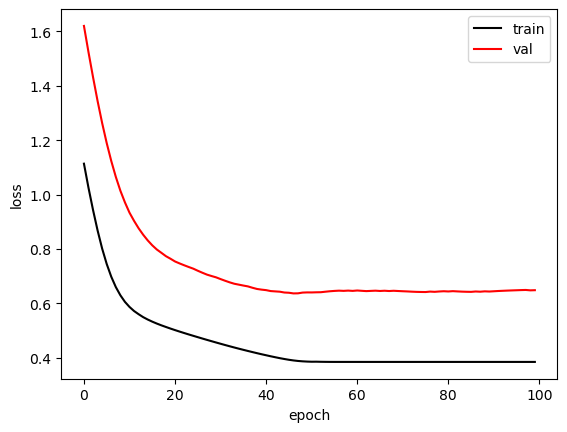

final train mae: 0.385
final val mae:   0.649
final train rmse: 0.506
final train rmse: 0.747


In [229]:
model_1 = build_model_1()
model_1.summary()

history_1 = model_1.fit(
  x=x_train[['total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=100,
  batch_size=40,
  validation_data=(
      x_val[['total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=False)

show_history(history_1)

### Model 2: Linear Regression (Adam)

</br> Input - Total Emissions
</br>Output - Avg Temp
</br> Requires fewer epochs to converge than standard SGD regression

In [8]:
def build_model_2():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Total Emissions')

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(tot_em)

  model = tf.keras.Model(inputs=[tot_em],
                         outputs=temp,
                         name='Model_2')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Total Emissions (InputLaye  [(None, 1)]               0         
 r)                                                              
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


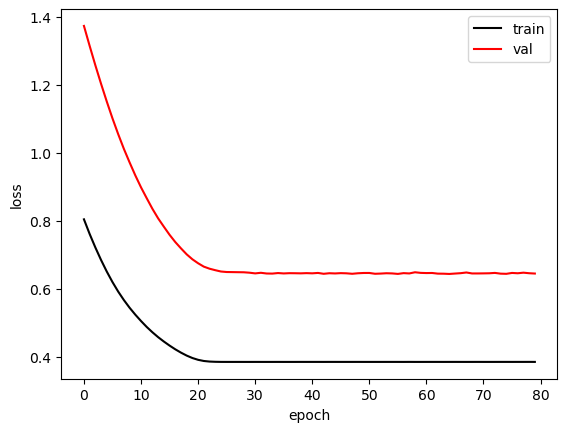

final train mae: 0.385
final val mae:   0.645
final train rmse: 0.506
final train rmse: 0.744


In [9]:
model_2 = build_model_2()
model_2.summary()

history_2 = model_2.fit(
  x=x_train[['total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=80,
  batch_size=80,
  validation_data=(
      x_val[['total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=False)

show_history(history_2)

### Model 3: Linear Regression (Adam) using Cumulative Sum of Total Emissions

</br> Input - Cumulative Sum of Total Emissions
</br>Output - Avg Temp
</br> Very little difference to Model 2

In [42]:
def build_model_3():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  cum_sum_tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Cum Sum Total Emissions')

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(cum_sum_tot_em)

  model = tf.keras.Model(inputs=[cum_sum_tot_em],
                         outputs=temp,
                         name='Model_3')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Cum Sum Total Emissions (I  [(None, 1)]               0         
 nputLayer)                                                      
                                                                 
 Temp (Dense)                (None, 1)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


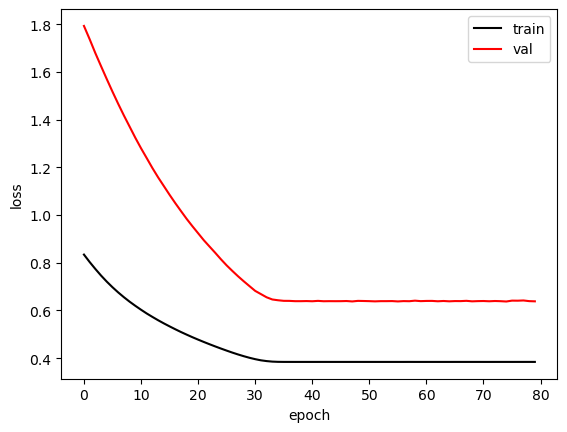

final train mae: 0.384
final val mae:   0.638
final train rmse: 0.505
final train rmse: 0.740


In [43]:
model_3 = build_model_3()
model_3.summary()

history_3 = model_3.fit(
  x=x_train[['cum_sum_total_emission']],
  y=Y_train[['average_temperature_°c']],
  epochs=80,
  batch_size=100,
  validation_data=(
      x_val[['cum_sum_total_emission']],
      Y_val[['average_temperature_°c']]),
  verbose=False)

show_history(history_3)

### Model 4: Linear Regression (Adam) using Cumulative Sum of Total Emissions & Urban Pop

</br> Input - Cumulative Sum of Total Emissions & Urban Population
</br>Output - Avg Temp
</br> Very little difference to model 3

In [12]:
def build_model_4():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  cum_sum_tot_em = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Cum Sum Total Emissions')
  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')

  features = tf.keras.layers.Concatenate()([cum_sum_tot_em, urban_pop])

  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[cum_sum_tot_em, urban_pop],
                         outputs=temp,
                         name='Model_4')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Cum Sum Total Emissions (I  [(None, 1)]                  0         []                            
 nputLayer)                                                                                       
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 concatenate (Concatenate)   (None, 2)                    0         ['Cum Sum Total Emissions[0][0
                                                                    ]',                     

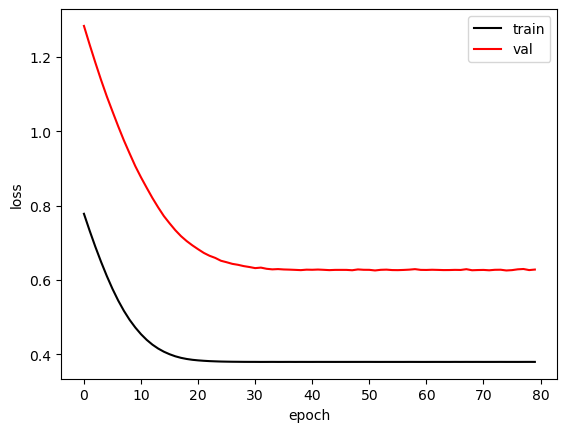

final train mae: 0.380
final val mae:   0.628
final train rmse: 0.501
final train rmse: 0.724


In [13]:
model_4 = build_model_4()
model_4.summary()

history_4 = model_4.fit(
  x={
      'Cum Sum Total Emissions': x_train[['cum_sum_total_emission']],
      'Urban Population': x_train[['log_urban_population']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=80,
  batch_size=100,
  validation_data=(
      {
      'Cum Sum Total Emissions': x_val[['cum_sum_total_emission']],
      'Urban Population': x_val[['log_urban_population']]
    },
      Y_val[['average_temperature_°c']]),
  verbose=False)

show_history(history_4)

### Model 5: Linear Regression (Adam) Kitchen Sink 

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>Still some noise in validation loss, but shape of loss curves look good and training loss is less than val loss. Could maybe use a few more epochs for convergence. 

In [58]:
#Create a list of sub-regions and areas 
sub_regions = train.groupby('sub-region')['sub-region'].count().index.tolist()
areas = train.groupby('area')['area'].count().index.tolist()

In [15]:
def build_model_5():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=sub_regions, 
                                               output_mode='one_hot')(sub_region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id])
    
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region],
                         outputs=temp,
                         name='Model_5')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

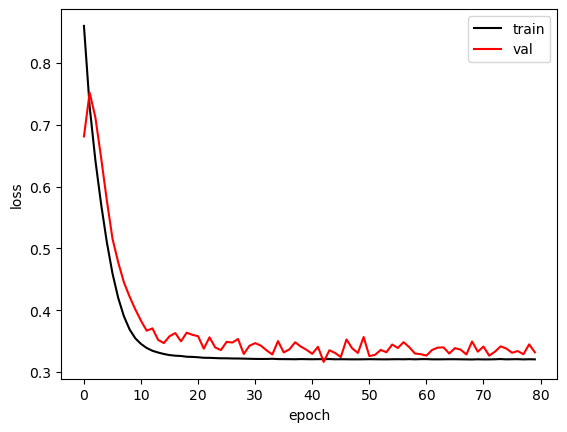

final train mae: 0.320
final val mae:   0.332
final train rmse: 0.435
final train rmse: 0.426


In [16]:
model_5 = build_model_5()
model_5.summary()

history_5 = model_5.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=80,
  batch_size=100,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history_5)

#### Model 6 - Linear Regression (Adam) Kitchen Sink (Hyperparameter Tuning)

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>Added exponential decay learning rate scheduler. Increased epochs and batch size to 300 to try to reduce noise. Small amount of overfitting to training data which is prefereable. Less noise in validation loss. 

In [17]:
def build_model_6():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=sub_regions, 
                                               output_mode='one_hot')(sub_region)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id])
    
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region],
                         outputs=temp,
                         name='Model_6')
  
  initial_learning_rate = 0.0001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Crop Residues (InputLayer)  [(None, 1)]                  0         []                      

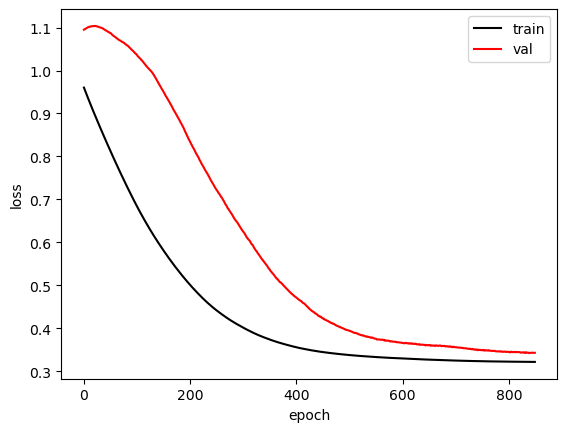

final train mae: 0.321
final val mae:   0.343
final train rmse: 0.435
final train rmse: 0.435


In [18]:
model_6 = build_model_6()
model_6.summary()

history_6 = model_6.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=850,
  batch_size=400,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history_6)

#### Model 6b - Linear Regression (Adam) Kitchen Sink (Hyperparameter Tuning) + Area feature

</br> Input - MEI, Urban Pop, All CO2 emission inputs, Sub-region, Area
</br>Output - Avg Temp
</br>Added exponential decay learning rate scheduler. Increased epochs and batch size to 300 to try to reduce noise. Small amount of overfitting to training data which is prefereable. Less noise in validation loss. 

In [19]:
def build_model_6b():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=sub_regions, 
                                               output_mode='one_hot')(sub_region)

  area_id = tf.keras.layers.StringLookup(vocabulary=areas,
                                               output_mode='one_hot')(area)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id,
                                            area_id])
    
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region,
                                            area],
                         outputs=temp,
                         name='Model_6b')
  
  initial_learning_rate = 0.0001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_6b"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Area (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                     

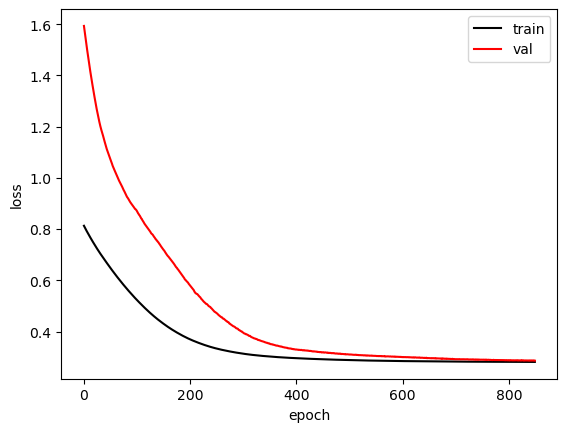

final train mae: 0.281
final val mae:   0.287
final train rmse: 0.397
final train rmse: 0.366


In [20]:
model_6b = build_model_6b()
model_6b.summary()

history_6b = model_6b.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']],
      'Area':x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=850,
  batch_size=400,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']],
      'Area':x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history_6b)

#### Model 6c - Linear Regression (Adam) Kitchen Sink (Hyperparameter Tuning) + Embeddings

</br> Input - MEI, Urban Pop, All CO2 emission inputs, Sub-region (embedding), Area (embedding)
</br>Output - Avg Temp
</br>Added exponential decay learning rate scheduler. Increased epochs and batch size to 300 to try to reduce noise. Small amount of overfitting to training data which is prefereable. Less noise in validation loss. 

In [59]:
def build_model_6c():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)
  tf.keras.utils.set_random_seed(0)
  
  # input features
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='MEI')
  sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Crop Residues')
  sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Rice Cultivation')
  sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Drained Organic Soils CO2')
  sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Net Forest Conversion')
  sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Fires')
  sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Manure Management')
  sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Food Systems')
  sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='IPPU Total')
  sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='On Farm Energy Use')
  sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='Forestland')

  # embeddings
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')

  embed_dim = 5

  sub_region_binned = tf.keras.layers.StringLookup(vocabulary=sub_regions)(sub_region)
  area_binned = tf.keras.layers.StringLookup(vocabulary=areas)(area)

  sub_region_embed = tf.keras.layers.Embedding(
      input_dim=18, output_dim=embed_dim, input_length=1)(sub_region_binned)
  area_embed = tf.keras.layers.Embedding(
      input_dim=191, output_dim=embed_dim, input_length=1)(area_binned)

  # combine embedding layers
  embeddings = tf.keras.layers.Add()(
      [sub_region_embed, area_embed])

  # flatten embedding layers  
  flat_embed = tf.keras.layers.Flatten()(embeddings)

  # concatenate with other features
  features = tf.keras.layers.Concatenate()(
      [mei, sum_log_crop_residues, sum_log_rice_cultivation, 
       sum_log_drained_organic_soils_co2, sum_log_net_forest_conversion,
       sum_log_fires, sum_log_manure_mgmt, sum_log_food_systems, sum_log_ippu_tot,
       sum_log_on_farm_energy_use, sum_forestland,
       flat_embed])
  
 
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(features)

  model = tf.keras.Model(inputs=[
                            mei, sum_log_crop_residues, sum_log_rice_cultivation, 
                            sum_log_drained_organic_soils_co2, 
                            sum_log_net_forest_conversion,
                            sum_log_fires, sum_log_manure_mgmt, 
                            sum_log_food_systems, sum_log_ippu_tot,
                            sum_log_on_farm_energy_use, sum_forestland, 
                            sub_region, 
                            area],
                         outputs=temp,
                         name='Model_6c')

  initial_learning_rate = 0.0001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )
      
  return model

Model: "Model_6c"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Area (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 string_lookup (StringLooku  (None, 1)                    0         ['Sub Region[0][0]']          
 p)                                                                                               
                                                                                                  
 string_lookup_1 (StringLoo  (None, 1)                    0         ['Area[0][0]']         

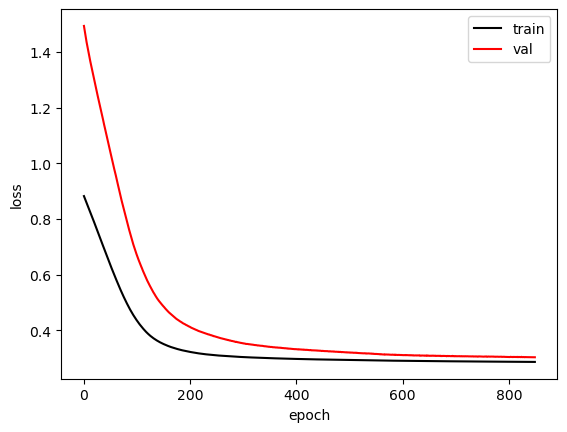

final train mae: 0.287
final val mae:   0.304
final train rmse: 0.407
final train rmse: 0.385


In [60]:
model_6c = build_model_6c()
model_6c.summary()

history_6c = model_6c.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']],
      'Area':x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=850,
  batch_size=400,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']],
      'Area':x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history_6c)

### Model 7: FFNN (1 Hidden Layer)

</br> Input - MEI, Urban Pop, All CO2 emission inputs, Sub-region, Area
</br>Output - Avg Temp
</br>1 Hidden Layer Size: 128
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [23]:
def build_model_7():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=sub_regions, 
                                               output_mode='one_hot')(sub_region)

  area_id = tf.keras.layers.StringLookup(vocabulary=areas, 
                                               output_mode='one_hot')(area)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id,
                                            area_id])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_1)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region,
                                            area],
                         outputs=temp,
                         name='Model_7')
  
  initial_learning_rate = 0.00001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Area (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                      

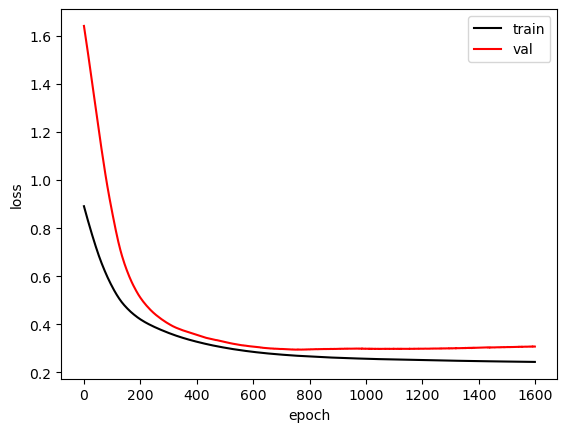

final train mae: 0.243
final val mae:   0.307
final train rmse: 0.360
final train rmse: 0.382


In [24]:
model_7 = build_model_7()
model_7.summary()

history_7 = model_7.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=1600,
  batch_size=600,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history_7)

### Model 7b: FFNN (1 Hidden Layer) + Embeddings

</br> Input - MEI, Urban Pop, All CO2 emission inputs, Sub-region (embeddings), Area (embeddings)
</br>Output - Avg Temp
</br>1 Hidden Layer Size: 128
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [25]:
def build_model_7b():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')

  # embeddings
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')

  embed_dim = 5

  sub_region_binned = tf.keras.layers.StringLookup(vocabulary=sub_regions)(sub_region)
  area_binned = tf.keras.layers.StringLookup(vocabulary=areas)(area)

  sub_region_embed = tf.keras.layers.Embedding(
      input_dim=18, output_dim=embed_dim, input_length=1)(sub_region_binned)
  area_embed = tf.keras.layers.Embedding(
      input_dim=191, output_dim=embed_dim, input_length=1)(area_binned)

  # combine embedding layers
  embeddings = tf.keras.layers.Add()(
      [sub_region_embed, area_embed])

  # flatten embedding layers  
  flat_embed = tf.keras.layers.Flatten()(embeddings)

  #Concatenate with other features
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            flat_embed])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_1)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region,
                                            area],
                         outputs=temp,
                         name='Model_7b')
  
  initial_learning_rate = 0.00001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_7b"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Area (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 string_lookup (StringLooku  (None, 1)                    0         ['Sub Region[0][0]']          
 p)                                                                                               
                                                                                                  
 string_lookup_1 (StringLoo  (None, 1)                    0         ['Area[0][0]']         

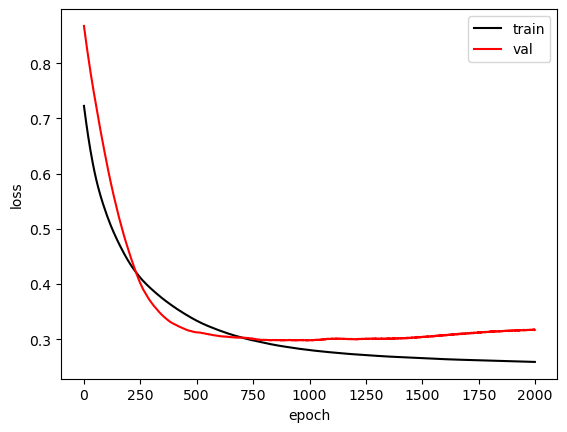

final train mae: 0.259
final val mae:   0.317
final train rmse: 0.374
final train rmse: 0.391


In [26]:
model_7b = build_model_7b()
model_7b.summary()

history_7b = model_7b.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=2000,
  batch_size=600,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history_7b)

### Model 8: FFNN (2 Hidden Layers)

</br> Input - MEI, Urban Pop, All CO2 emission inputs, Sub-region, Area
</br>Output - Avg Temp
</br>1st Hidden Layer Size: 128
</br>2nd Hidden Layer Size: 128
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [27]:
def build_model_8():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=sub_regions, 
                                               output_mode='one_hot')(sub_region)

  area_id = tf.keras.layers.StringLookup(vocabulary=areas, 
                                               output_mode='one_hot')(area)

    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id,
                                            area_id
                                           ])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)

  hidden_2 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_2')(hidden_1)

  # dropout_1 = tf.keras.layers.Dropout(0.1, name='Dropout_1')(hidden_2)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_2)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region,
                                            area
                                            ],
                         outputs=temp,
                         name='Model_8')
  
  initial_learning_rate = 0.00001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Area (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                      

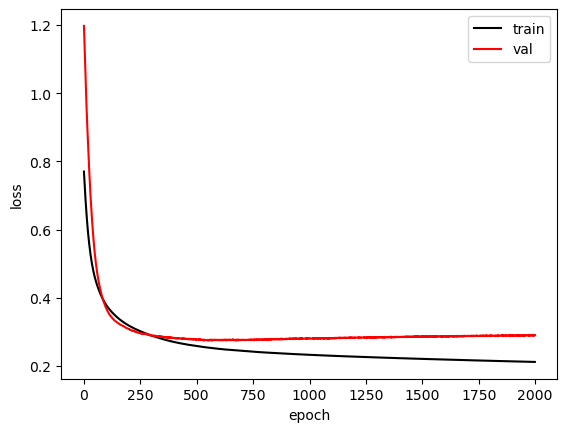

final train mae: 0.212
final val mae:   0.290
final train rmse: 0.335
final train rmse: 0.367


In [28]:
model_8 = build_model_8()
model_8.summary()

history_8 = model_8.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=2000,
  batch_size=500,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history_8)

### Model 8b: FFNN (2 Hidden Layers) + Embeddings

</br> Input - MEI, Urban Pop, All CO2 emission inputs, Sub-region (embeddings), Area (embeddings)
</br>Output - Avg Temp
</br>1st Hidden Layer Size: 128
</br>2nd Hidden Layer Size: 128
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [64]:
def build_model_8b():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')

  # embeddings
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')

  embed_dim = 5

  sub_region_binned = tf.keras.layers.StringLookup(vocabulary=sub_regions)(sub_region)
  area_binned = tf.keras.layers.StringLookup(vocabulary=areas)(area)

  sub_region_embed = tf.keras.layers.Embedding(
      input_dim=18, output_dim=embed_dim, input_length=1)(sub_region_binned)
  area_embed = tf.keras.layers.Embedding(
      input_dim=191, output_dim=embed_dim, input_length=1)(area_binned)

  # combine embedding layers
  embeddings = tf.keras.layers.Add()(
      [sub_region_embed, area_embed])

  # flatten embedding layers  
  flat_embed = tf.keras.layers.Flatten()(embeddings)

  #Concatenate with other features
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            flat_embed])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)

  hidden_2 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_2')(hidden_1)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_2)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region,
                                            area],
                         outputs=temp,
                         name='Model_8b')
  
  initial_learning_rate = 0.00001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_8b"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Area (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 string_lookup (StringLooku  (None, 1)                    0         ['Sub Region[0][0]']          
 p)                                                                                               
                                                                                                  
 string_lookup_1 (StringLoo  (None, 1)                    0         ['Area[0][0]']         

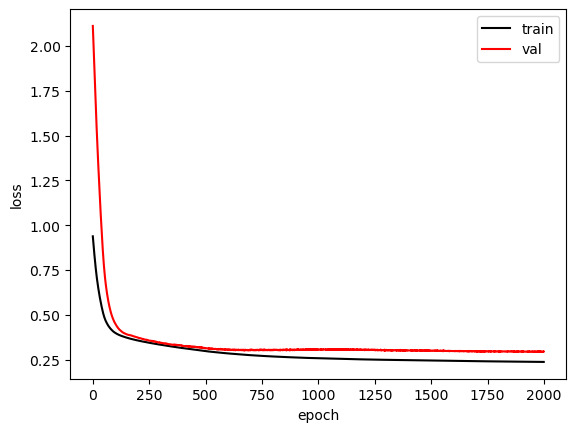

final train mae: 0.238
final val mae:   0.296
final train rmse: 0.355
final train rmse: 0.372


In [65]:
model_8b = build_model_8b()
model_8b.summary()

history_8b = model_8b.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=2000,
  batch_size=500,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history_8b)

### Model 9: FFNN (3 Hidden Layers)

</br> Input - MEI, Urban Pop, All CO2 emission inputs, Sub-region, Area
</br>Output - Avg Temp
</br>1st Hidden Layer Size: 128
</br>2nd Hidden Layer Size: 128
</br>3rd Hidden Layer Size: 128
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [31]:
def build_model_9():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')
    
  sub_region_id = tf.keras.layers.StringLookup(vocabulary=sub_regions, 
                                               output_mode='one_hot')(sub_region)

  area_id = tf.keras.layers.StringLookup(vocabulary=areas, 
                                               output_mode='one_hot')(area)
    
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region_id,
                                            area_id
                                           ])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)

  hidden_2 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_2')(hidden_1)

  hidden_3 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_3')(hidden_2)

  # dropout_1 = tf.keras.layers.Dropout(0.1, name='Dropout_1')(hidden_2)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_3)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region,
                                            area
                                            ],
                         outputs=temp,
                         name='Model_9')
  
  initial_learning_rate = 0.000001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Area (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Urban Population (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 MEI (InputLayer)            [(None, 1)]                  0         []                      

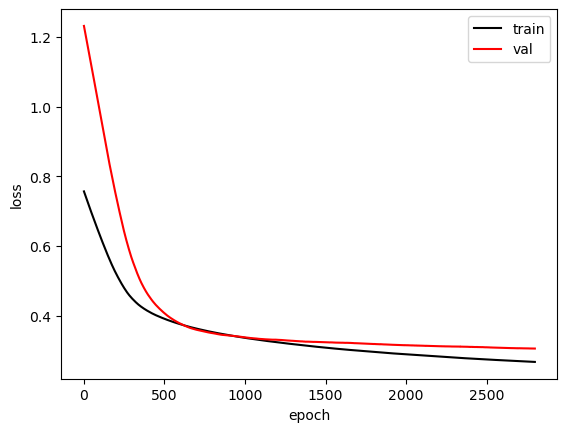

final train mae: 0.267
final val mae:   0.306
final train rmse: 0.381
final train rmse: 0.387


In [32]:
model_9 = build_model_9()
model_9.summary()

history_9 = model_9.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=2800,
  batch_size=400,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history_9)

### Model 9b: FFNN (3 Hidden Layers) + Embeddings

</br> Input - MEI, Urban Pop, All CO2 emission inputs, Sub-region (Embeddings), Area (Embeddings)
</br>Output - Avg Temp
</br>1st Hidden Layer Size: 128
</br>2nd Hidden Layer Size: 128
</br>3rd Hidden Layer Size: 128
</br>Includes exponential decay LR scheduler
</br> Did not include dropout layer since dropout led to underfitting (val loss was lower than train loss)

In [33]:
def build_model_9b():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  urban_pop = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Urban Population')
  mei = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='MEI')
  cum_sum_log_crop_residues = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Crop Residues')
  cum_sum_log_rice_cultivation = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Rice Cultivation')
  cum_sum_log_drained_organic_soils_co2 = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Drained Organic Soils CO2')
  cum_sum_log_net_forest_conversion = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Net Forest Conversion')
  cum_sum_log_fires = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Fires')
  cum_sum_log_manure_mgmt = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Manure Management')
  cum_sum_log_food_systems = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Food Systems')
  cum_sum_log_ippu_tot = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='IPPU Total')
  cum_sum_log_on_farm_energy_use = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='On Farm Energy Use')
  cum_sum_forestland = tf.keras.layers.Input(shape=(1,), dtype=tf.float64, name='Forestland')
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')

  # embeddings
  sub_region = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Sub Region')
  area = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='Area')

  embed_dim = 5

  sub_region_binned = tf.keras.layers.StringLookup(vocabulary=sub_regions)(sub_region)
  area_binned = tf.keras.layers.StringLookup(vocabulary=areas)(area)

  sub_region_embed = tf.keras.layers.Embedding(
      input_dim=18, output_dim=embed_dim, input_length=1)(sub_region_binned)
  area_embed = tf.keras.layers.Embedding(
      input_dim=191, output_dim=embed_dim, input_length=1)(area_binned)

  # combine embedding layers
  embeddings = tf.keras.layers.Add()(
      [sub_region_embed, area_embed])

  # flatten embedding layers  
  flat_embed = tf.keras.layers.Flatten()(embeddings)

  #Concatenate with other features
  features = tf.keras.layers.Concatenate()([urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            flat_embed])
  
  hidden_1 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_1')(features)

  hidden_2 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_2')(hidden_1)
    
  hidden_3 = tf.keras.layers.Dense(
      units=128, activation='relu', name='Hidden_Layer_3')(hidden_2)
  
  temp = tf.keras.layers.Dense(
      units=1, activation=None, name='Temp')(hidden_3)

  model = tf.keras.Model(inputs=[urban_pop,
                                            mei,
                                            cum_sum_log_crop_residues,
                                            cum_sum_log_rice_cultivation,
                                            cum_sum_log_drained_organic_soils_co2,
                                            cum_sum_log_net_forest_conversion,
                                            cum_sum_log_fires,
                                            cum_sum_log_manure_mgmt,
                                            cum_sum_log_food_systems,
                                            cum_sum_log_ippu_tot,
                                            cum_sum_log_on_farm_energy_use,
                                            cum_sum_forestland,
                                            sub_region,
                                            area],
                         outputs=temp,
                         name='Model_9b')
  
  initial_learning_rate = 0.000001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

  return model

Model: "Model_9b"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Sub Region (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Area (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 string_lookup (StringLooku  (None, 1)                    0         ['Sub Region[0][0]']          
 p)                                                                                               
                                                                                                  
 string_lookup_1 (StringLoo  (None, 1)                    0         ['Area[0][0]']         

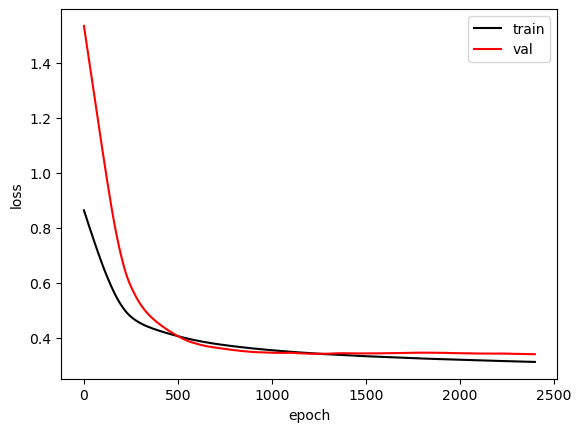

final train mae: 0.311
final val mae:   0.339
final train rmse: 0.429
final train rmse: 0.427


In [34]:
model_9b = build_model_9b()
model_9b.summary()

history_9b = model_9b.fit(
  x={
      'Urban Population': x_train[['urban_population']],
      'MEI': x_train[['mei']],
      'Crop Residues': x_train[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_train[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_train[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_train[['cum_sum_log_net_forest_conversion']],
      'Fires': x_train[['cum_sum_log_fires']],
      'Manure Management': x_train[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_train[['cum_sum_log_food_systems']],
      'IPPU Total': x_train[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_train[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_train[['cum_sum_forestland']],
      'Sub Region': x_train[['sub-region']],
      'Area': x_train[['area']]
    },
  y=Y_train[['average_temperature_°c']],
  epochs=2400,
  batch_size=400,
  validation_data=(
      {
      'Urban Population': x_val[['urban_population']],
      'MEI': x_val[['mei']],
      'Crop Residues': x_val[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_val[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_val[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_val[['cum_sum_log_net_forest_conversion']],
      'Fires': x_val[['cum_sum_log_fires']],
      'Manure Management': x_val[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_val[['cum_sum_log_food_systems']],
      'IPPU Total': x_val[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_val[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_val[['cum_sum_forestland']],
      'Sub Region': x_val[['sub-region']],
      'Area': x_val[['area']]
      },
      Y_val[['average_temperature_°c']]),
  verbose=0)

show_history(history_9b)

# Decision Trees

### Model 10: Kitchen Sink Approach - All Features tested in regression and FFNN models

Max_depth = 4 minimizes MAE

In [35]:
features = ['area','sub-region', 'urban_population',
                                            'mei',
                                            'cum_sum_log_crop_residues',
                                            'cum_sum_log_rice_cultivation',
                                            'cum_sum_log_drained_organic_soils_co2',
                                            'cum_sum_log_net_forest_conversion',
                                            'cum_sum_log_fires',
                                            'cum_sum_log_manure_mgmt',
                                            'cum_sum_log_food_systems',
                                            'cum_sum_log_ippu_tot',
                                            'cum_sum_log_on_farm_energy_use',
                                            'cum_sum_forestland']

x_train_1 = x_train[features]
x_val_1 = x_val[features]

area_dummies_train = pd.get_dummies(x_train['area'],
                                          drop_first=True)

area_dummies_val = pd.get_dummies(x_val['area'],
                                          drop_first=True)

sub_region_dummies_train = pd.get_dummies(x_train['sub-region'],
                                          drop_first=True)

sub_region_dummies_val = pd.get_dummies(x_val['sub-region'],
                                          drop_first=True)

x_train_1 = pd.concat([x_train_1, sub_region_dummies_train, area_dummies_train],
                    axis=1)

x_val_1 = pd.concat([x_val_1, sub_region_dummies_val, area_dummies_val],
                    axis=1)

x_train_1 = x_train_1.drop(labels=['area','sub-region'],axis=1)
x_val_1 = x_val_1.drop(labels=['area','sub-region'],axis=1)


In [36]:
dt_model_1 = DecisionTreeRegressor(criterion='absolute_error',random_state=44, max_depth=4)
dt_model_1.fit(x_train_1, Y_train)
predictions = dt_model_1.predict(x_val_1)

In [37]:
mae_1 = mae(Y_val,predictions)
rmse_1 = mse(Y_val,predictions, squared=False)

In [38]:
print('final val mae:   %.3f' %mae_1)
print('final val rmse:   %.3f' %rmse_1)

final val mae:   0.485
final val rmse:   0.581


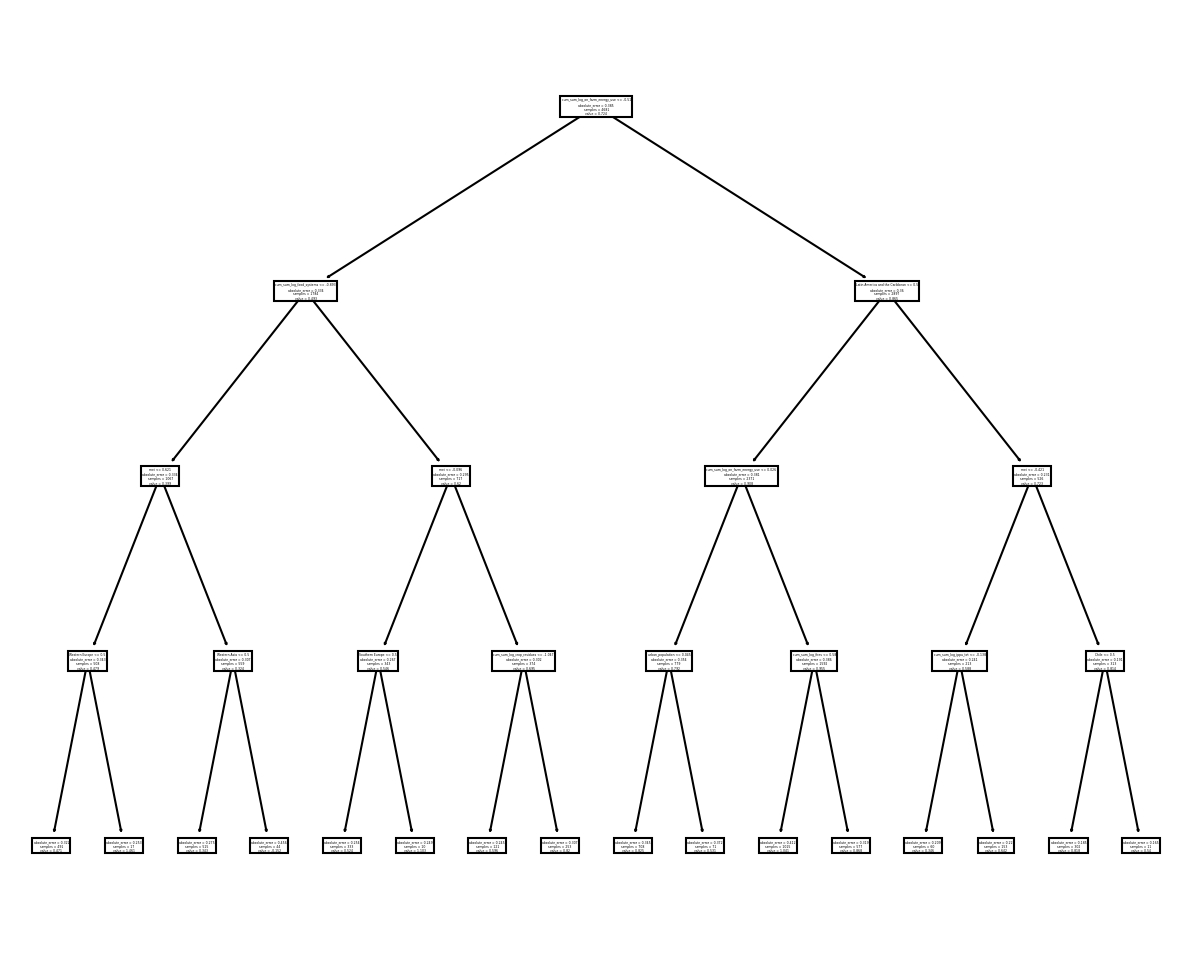

In [39]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,8), dpi=150)
plot_tree(dt_model_1, feature_names=x_train_1.columns);

### Model 11: Only CO2 features with correlation about 0.35 with target variable

Max_depth = 6 minimizes MAE

In [40]:
features = [                                'cum_sum_log_manure_mgmt',
                                            'cum_sum_log_food_systems',
                                            'cum_sum_log_ippu_tot',
                                            'cum_sum_log_on_farm_energy_use']

x_train_2 = x_train[features]
x_val_2 = x_val[features]

In [41]:
dt_model_2 = DecisionTreeRegressor(criterion='absolute_error',random_state=44, max_depth=6)
dt_model_2.fit(x_train_2, Y_train)
predictions = dt_model_2.predict(x_val_2)

In [42]:
mae_2 = mae(Y_val,predictions)
rmse_2 = mse(Y_val,predictions, squared=False)

In [43]:
print('final val mae:   %.3f' %mae_2)
print('final val rmse:   %.3f' %rmse_2)

final val mae:   0.471
final val rmse:   0.572


### Model 12: Add Year

Max_depth = 6 minimizes MAE

In [44]:
features = [                                'year',
                                            'cum_sum_log_manure_mgmt',
                                            'cum_sum_log_food_systems',
                                            'cum_sum_log_ippu_tot',
                                            'cum_sum_log_on_farm_energy_use']

x_train_3 = x_train[features]
x_val_3 = x_val[features]

In [45]:
dt_model_3 = DecisionTreeRegressor(criterion='absolute_error',random_state=44, max_depth=6)
dt_model_3.fit(x_train_3, Y_train)
predictions = dt_model_3.predict(x_val_3)

In [46]:
mae_3 = mae(Y_val,predictions)
rmse_3 = mse(Y_val,predictions, squared=False)

In [47]:
print('final val mae:   %.3f' %mae_3)
print('final val rmse:   %.3f' %rmse_3)

final val mae:   0.408
final val rmse:   0.513


In [48]:
dt_model_3.feature_importances_

array([0.63757742, 0.074908  , 0.08276041, 0.07772363, 0.12703054])

### Model 13: Limit to features with correlation >= 0.38 with target variable

Max_depth = 6 minimizes MAE

In [185]:
features = [                                'year',
                                            'cum_sum_log_food_systems',
                                            'cum_sum_log_on_farm_energy_use']

x_train_4 = x_train[features]
x_val_4 = x_val[features]
x_test_4 = x_test[features]

In [186]:
dt_model_4 = DecisionTreeRegressor(criterion='absolute_error',random_state=44, max_depth=6)
dt_model_4.fit(x_train_4, Y_train)
pred_train = dt_model_4.predict(x_train_4)
pred_val = dt_model_4.predict(x_val_4)

In [187]:
mae_train_13 = round(mae(Y_train,pred_train),3)
rmse_train_13 = round(mse(Y_train,pred_train, squared=False),3)
mae_val_13 = round(mae(Y_val,pred_val),3)
rmse_val_13 = round(mse(Y_val,pred_val, squared=False),3)

In [188]:
print('final train mae:   %.3f' %mae_train_13)
print('final train rmse:   %.3f' %rmse_train_13)
print('final val mae:   %.3f' %mae_val_13)
print('final val rmse:   %.3f' %rmse_val_13)

final train mae:   0.314
final train rmse:   0.429
final val mae:   0.384
final val rmse:   0.488


## Random Forests

### Model 14: RF based on high correlation features found for decision tree model

In [189]:
rf_model = RandomForestRegressor(criterion='absolute_error',random_state=44, max_depth=5, n_estimators=20, max_features=None, bootstrap=False)
rf_model.fit(x_train_4, Y_train)
pred_train = rf_model.predict(x_train_4)
pred_val = rf_model.predict(x_val_4)

In [190]:
mae_train_14 = round(mae(Y_train,pred_train),3)
rmse_train_14 = round(mse(Y_train,pred_train, squared=False),3)
mae_val_14 = round(mae(Y_val,pred_val),3)
rmse_val_14 = round(mse(Y_val,pred_val, squared=False),3)

In [191]:
print('final train mae:   %.3f' %mae_train_14)
print('final train rmse:   %.3f' %rmse_train_14)
print('final val mae:   %.3f' %mae_val_14)
print('final val rmse:   %.3f' %rmse_val_14)

final train mae:   0.320
final train rmse:   0.436
final val mae:   0.401
final val rmse:   0.512


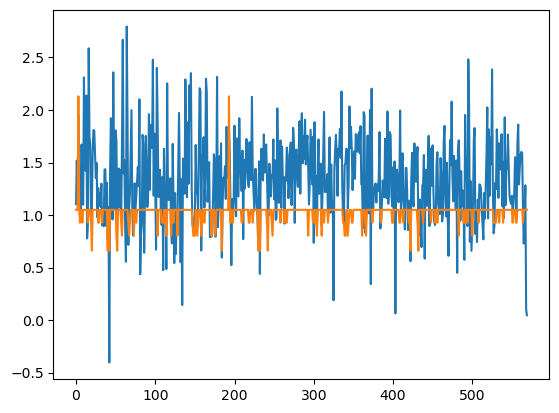

In [192]:
plt.plot(Y_val.index, Y_val.values)
plt.plot(Y_val.index, predictions)

## Model 15: Extra Tree Regressor

In [57]:
etr_model = ExtraTreesRegressor(criterion='absolute_error',random_state=44, max_depth=6, n_estimators=10, max_features=None) 
etr_model.fit(x_train_4, Y_train)
predictions = etr_model.predict(x_val_4)

In [58]:
mae_etr = mae(Y_val,predictions)
rmse_etr = mse(Y_val,predictions, squared=False)

In [59]:
print('final val mae:   %.3f' %mae_etr)
print('final val rmse:   %.3f' %rmse_etr)

final val mae:   0.392
final val rmse:   0.500


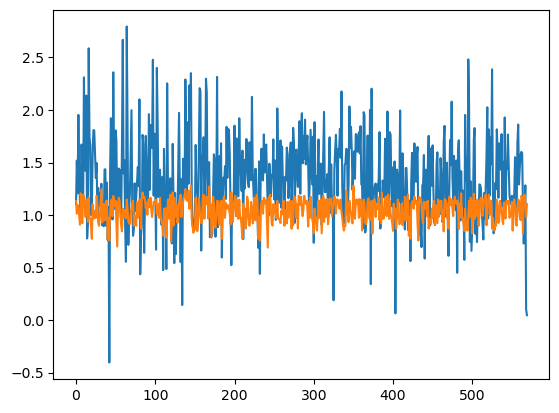

In [60]:
plt.plot(Y_val.index, Y_val.values)
plt.plot(Y_val.index, predictions)

### Model 16: XGBoost

In [193]:
features = [                                'year',
                                            'cum_sum_log_food_systems',
                                            'cum_sum_log_on_farm_energy_use']

x_train_4 = x_train[features]
x_val_4 = x_val[features]

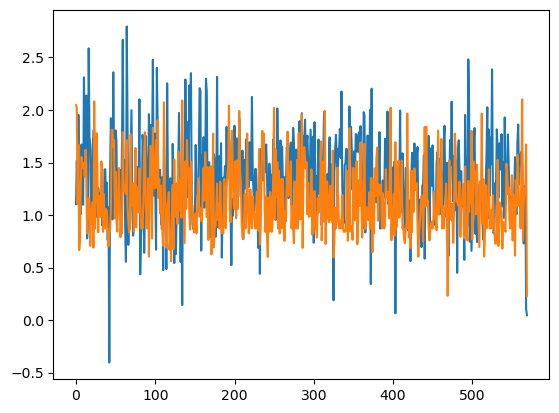

In [194]:
import xgboost as xgb

# fit the model
my_xgb = xgb.XGBRegressor()
my_xgb.fit(x_train_4, Y_train)

# predict on the same period
preds_train = my_xgb.predict(x_train_4)
preds_val = my_xgb.predict(x_val_4)

# plot what has been learned
plt.plot(Y_val.index, Y_val.values)
plt.plot(Y_val.index, preds)

In [195]:
mae_train_16 = round(mae(Y_train,preds_train),3)
rmse_train_16 = round(mse(Y_train,preds_train, squared=False),3)
mae_val_16 = round(mae(Y_val,preds_val),3)
rmse_val_16 = round(mse(Y_val,preds_val, squared=False),3)

In [196]:
print('final train mae:   %.3f' %mae_train_16)
print('final train rmse:   %.3f' %rmse_train_16)
print('final val mae:   %.3f' %mae_val_16)
print('final val rmse:   %.3f' %rmse_val_16)

final train mae:   0.206
final train rmse:   0.278
final val mae:   0.407
final val rmse:   0.517


## LSTM

### Model 17: LSTM (Long Short Term Memory)

</br> Input - MEI, Urban Pop, All CO2 emission inputs
</br>Output - Avg Temp
</br>Includes exponential decay LR scheduler

In [7]:
train_lstm = train.sort_values(['area','year']).reset_index(drop=True)
train.shape

(4681, 48)

In [8]:
val_lstm = val.sort_values(['area','year']).reset_index(drop=True)
val.shape

(570, 48)

In [9]:
test_lstm = test.sort_values(['area','year']).reset_index(drop=True)
test.shape

(570, 48)

In [10]:
features = ['year',
            'area',
            'sub-region',
            'urban_population',
            'mei',
            'cum_sum_log_crop_residues',
            'cum_sum_log_rice_cultivation',
            'cum_sum_log_drained_organic_soils_co2',
            'cum_sum_log_net_forest_conversion',
            'cum_sum_log_fires',
            'cum_sum_log_manure_mgmt',
            'cum_sum_log_food_systems',
            'cum_sum_log_ippu_tot',
            'cum_sum_log_on_farm_energy_use',
            'cum_sum_forestland',
            'average_temperature_°c']

train_lstm = train_lstm[features]
val_lstm = val_lstm[features]
test_lstm = test_lstm[features]

In [11]:
agg_train = train_lstm.groupby('area').sum()
agg_train.head()

,year,urban_population,mei,cum_sum_log_crop_residues,cum_sum_log_rice_cultivation,cum_sum_log_drained_organic_soils_co2,cum_sum_log_net_forest_conversion,cum_sum_log_fires,cum_sum_log_manure_mgmt,cum_sum_log_food_systems,cum_sum_log_ippu_tot,cum_sum_log_on_farm_energy_use,cum_sum_forestland,average_temperature_°c
area,,,,,,,,,,,,,,
Afghanistan,50050,-5.236087,-2.583333,9.814858,5.205943,-18.166267,-21.581831,-5.627949,6.059289,-2.768944,-13.653029,22.084143,5.311765,18.347000
Albania,50050,-6.685379,-2.583333,-2.999303,-11.170218,6.509985,-21.581831,-7.855573,1.513338,-6.899834,-4.501250,-3.207665,5.670532,17.995417
Algeria,50050,0.546039,-2.583333,8.512066,-25.453132,-18.166267,-0.736706,6.451740,6.476133,9.672907,3.962128,-3.250784,5.536773,27.315083
Andorra,50050,-7.194387,-2.583333,11.463283,7.297943,-18.166267,-21.581831,-21.288424,7.713736,-12.695721,-2.961787,-8.382151,5.768470,27.690500
Angola,50050,-3.406520,-2.583333,-0.429090,-9.674036,12.412896,22.007167,40.501281,4.427459,-0.986452,-7.731921,-9.891681,5.768470,15.379833


In [12]:
agg_train = agg_train[agg_train['year'] != 50050]
agg_train.index


Index(['Armenia', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Croatia', 'Czechia', 'Eritrea', 'Estonia', 'Georgia', 'Kazakhstan',
       'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Marshall Islands',
       'Micronesia (Federated States of)', 'North Macedonia',
       'Republic of Moldova', 'Russian Federation', 'Slovakia', 'Slovenia',
       'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan'],
      dtype='object', name='area')

In [13]:
countries = ['Armenia', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Croatia', 'Czechia', 'Eritrea', 'Estonia', 'Georgia', 'Kazakhstan',
       'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Marshall Islands',
       'Micronesia (Federated States of)', 'North Macedonia',
       'Republic of Moldova', 'Russian Federation', 'Slovakia', 'Slovenia',
       'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']

for country in countries:
    train_lstm = train_lstm[train_lstm['area'] != country]

In [14]:
agg_val = val_lstm.groupby('area').sum()
agg_val.head()

,year,urban_population,mei,cum_sum_log_crop_residues,cum_sum_log_rice_cultivation,cum_sum_log_drained_organic_soils_co2,cum_sum_log_net_forest_conversion,cum_sum_log_fires,cum_sum_log_manure_mgmt,cum_sum_log_food_systems,cum_sum_log_ippu_tot,cum_sum_log_on_farm_energy_use,cum_sum_forestland,average_temperature_°c
area,,,,,,,,,,,,,,
Afghanistan,6048,-0.461637,1.2,6.275596,5.725441,-2.179952,-2.589820,0.753573,6.418419,5.057819,2.132756,10.191574,0.622879,4.233250
Albania,6048,-0.786565,1.2,2.806095,2.827803,3.966877,-2.589820,0.318894,5.075274,3.803016,4.226404,3.844627,0.647940,4.100667
Algeria,6048,0.487960,1.2,5.928417,-2.216966,-2.179952,1.867764,4.184596,6.492107,7.907752,6.724818,4.261514,0.612021,4.380083
Andorra,6048,-0.863181,1.2,6.350188,6.220093,-2.179952,-2.589820,-2.554611,6.615339,1.782643,4.646473,2.287848,0.692216,5.555250
Angola,6048,-0.003204,1.2,4.012949,2.532666,5.428214,8.661871,12.856525,6.051348,5.290905,3.865672,3.337943,0.692216,3.808000


In [15]:
agg_val = agg_val[agg_val['year'] != 6048]
agg_val.index

Index([], dtype='object', name='area')

In [16]:
countries = ['Armenia', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Croatia', 'Czechia', 'Eritrea', 'Estonia', 'Georgia', 'Kazakhstan',
       'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Marshall Islands',
       'Micronesia (Federated States of)', 'North Macedonia',
       'Republic of Moldova', 'Russian Federation', 'Slovakia', 'Slovenia',
       'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']

for country in countries:
    val_lstm = val_lstm[val_lstm['area'] != country]

In [17]:
agg_test = test_lstm.groupby('area').sum()
agg_test.head()

,year,urban_population,mei,cum_sum_log_crop_residues,cum_sum_log_rice_cultivation,cum_sum_log_drained_organic_soils_co2,cum_sum_log_net_forest_conversion,cum_sum_log_fires,cum_sum_log_manure_mgmt,cum_sum_log_food_systems,cum_sum_log_ippu_tot,cum_sum_log_on_farm_energy_use,cum_sum_forestland,average_temperature_°c
area,,,,,,,,,,,,,,
Afghanistan,6057,-0.418841,-0.675,7.371224,6.758619,-2.179952,-2.589820,0.907785,7.654220,6.328294,2.998186,11.857540,0.624110,2.748083
Albania,6057,-0.782397,-0.675,3.493542,3.752665,4.646126,-2.589820,0.527816,6.105521,4.837180,5.299517,4.791724,0.645138,5.391417
Algeria,6057,0.591625,-0.675,7.046915,-2.075865,-2.179952,2.679464,4.714474,7.746272,9.414159,8.149323,5.371903,0.608513,4.409333
Andorra,6057,-0.863205,-0.675,7.407852,7.365309,-2.179952,-2.589820,-2.554611,7.837067,2.664123,5.718558,2.969780,0.692216,6.554250
Angola,6057,0.116045,-0.675,5.025620,3.259103,6.267730,9.977222,14.562971,7.278902,6.504833,4.965908,4.604377,0.692216,4.320833


In [18]:
agg_test = agg_test[agg_test['year'] != 6057]
agg_test.index

Index([], dtype='object', name='area')

In [19]:
countries = ['Armenia', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
       'Croatia', 'Czechia', 'Eritrea', 'Estonia', 'Georgia', 'Kazakhstan',
       'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Marshall Islands',
       'Micronesia (Federated States of)', 'North Macedonia',
       'Republic of Moldova', 'Russian Federation', 'Slovakia', 'Slovenia',
       'Tajikistan', 'Turkmenistan', 'Ukraine', 'Uzbekistan']

for country in countries:
    test_lstm = test_lstm[test_lstm['area'] != country]

In [20]:
train_lstm['area'].nunique()

164

In [21]:
val_lstm['area'].nunique()

164

In [22]:
test_lstm['area'].nunique()

164

In [23]:
x_train_lstm = train_lstm.drop(['average_temperature_°c'], axis=1)
x_val_lstm = val_lstm.drop(['average_temperature_°c'], axis=1)
x_test_lstm = test_lstm.drop(['average_temperature_°c'], axis=1)

Y_train_lstm = pd.DataFrame(train_lstm['average_temperature_°c'])
Y_val_lstm = pd.DataFrame(val_lstm['average_temperature_°c'])
Y_test_lstm = pd.DataFrame(test_lstm['average_temperature_°c'])

In [24]:
sub_region_dummies = pd.get_dummies(
    x_train_lstm['sub-region'],
    drop_first = True)

x_train_lstm = pd.concat([x_train_lstm, sub_region_dummies],
                         axis=1)


In [25]:
x_train_lstm = x_train_lstm.drop(['year','area','sub-region'],axis=1)

In [26]:
sub_region_dummies = pd.get_dummies(
    x_val_lstm['sub-region'],
    drop_first = True)

x_val_lstm = pd.concat([x_val_lstm, sub_region_dummies],
                         axis=1)

In [27]:
x_val_lstm = x_val_lstm.drop(['year','area','sub-region'],axis=1)

In [28]:
sub_region_dummies = pd.get_dummies(
    x_test_lstm['sub-region'],
    drop_first = True)

x_test_lstm = pd.concat([x_test_lstm, sub_region_dummies],
                         axis=1)

In [29]:
x_test_lstm = x_test_lstm.drop(['year','area','sub-region'],axis=1)

In [30]:
x_train_lstm.shape
x_val_lstm.shape
x_test_lstm.shape

(492, 27)

In [31]:
x_train_lstm = x_train_lstm.to_numpy()
x_val_lstm = x_val_lstm.to_numpy()
x_test_lstm = x_test_lstm.to_numpy()

In [32]:
x_train_lstm = x_train_lstm.reshape((164, 25, 27))
x_val_lstm = x_val_lstm.reshape((164, 3, 27))
x_test_lstm = x_test_lstm.reshape((164, 3, 27))

In [33]:
Y_train_lstm = Y_train_lstm.to_numpy()
Y_val_lstm = Y_val_lstm.to_numpy()
Y_test_lstm = Y_test_lstm.to_numpy()

In [34]:
Y_train_lstm = Y_train_lstm.reshape((164, 25, 1))
Y_val_lstm = Y_val_lstm.reshape((164, 3, 1))
Y_test_lstm = Y_test_lstm.reshape((164, 3, 1))

In [35]:
def build_lstm_model():
    """
    Return a simple Keras model with a single LSTM layer, dropout later, 
    and then dense prediction layer.
    
    Args:
    lstm_hidden_units (int): units in the LSTM layer    
    
    Returns:
    model_lstm (tf.keras.Model) LSTM keras model with output dimension (None,1)
    """
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    
    model_lstm = None
    
    # instanntiate model
    model_lstm = tf.keras.Sequential()
    
    # add layers
    model_lstm.add(Bidirectional(LSTM(
        units=200,
        #recurrent_dropout=0.4,
        use_bias=True,
        return_sequences=True,
        name='LSTM1'), name='bidir-LSTM1'))    
    
    # model_lstm.add(LSTM(
    #     units=300,
    #     # recurrent_dropout=0.4,
    #     use_bias=True,
    #     return_sequences=True,
    #     name='LSTM1'))  
    
    # model_lstm.add(Dropout(
    #     rate=0.8,
    #     name='Dropout1'
    # ))
    
    model_lstm.add(Dense(
        units=128,
        activation='relu',
        name='Dense1'
    ))
    
    model_lstm.add(Dense(
        units=128,
        activation='relu',
        name='Dense2'
    ))
    
    
    model_lstm.add(Dense(
        units=1,
        activation=None,
        name='Dense3'))
    
    model_lstm.build(input_shape=(None,None,27))

    
    model_lstm.summary()

    # END CODE #
    return model_lstm

In [36]:
model_lstm = build_lstm_model()
output = model_lstm(x_train_lstm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidir-LSTM1 (Bidirectional  (None, None, 400)         364800    
 )                                                               
                                                                 
 Dense1 (Dense)              (None, None, 128)         51328     
                                                                 
 Dense2 (Dense)              (None, None, 128)         16512     
                                                                 
 Dense3 (Dense)              (None, None, 1)           129       
                                                                 
Total params: 432769 (1.65 MB)
Trainable params: 432769 (1.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
## compile and train:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

model_lstm.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss=tf.keras.losses.MeanAbsoluteError(),
      metrics=tf.keras.metrics.RootMeanSquaredError()
      )

# Train model
history_lstm = model_lstm.fit(x=x_train_lstm,
                y=Y_train_lstm,
                epochs=300,
                batch_size=1,
                validation_data=(x_val_lstm,
                                Y_val_lstm),
                verbose=0, #silence fit
                #callbacks=[tensorboard_callback]
)


show_history(history_lstm)

## Model Testing

### Model 1 - Baseline Linear Regression

Inputs: Total Emissions

In [230]:
model_1_preds = model_1.predict(x=x_test[['total_emission']])

18/18 [==============================] - 0s 2ms/step


In [231]:
model_1_mae = round(mae(Y_test, model_1_preds),3)
model_1_rmse = round(mse(Y_test, model_1_preds, squared=False),3)

In [232]:
print('Test MAE: %.3f' %model_1_mae)
print('Test RMSE: %.3f' %model_1_rmse)

Test MAE: 0.755
Test RMSE: 0.923


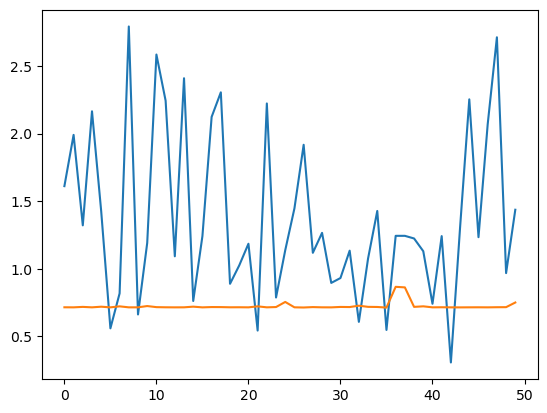

In [233]:
plt.plot(Y_test.index[0:50], Y_test.values[0:50])
plt.plot(Y_test.index[0:50], model_1_preds[0:50])

### Model 3 - Baseline Linear Regression (Adam)

Inputs: Cumulative Sum of Total Emissions

In [44]:
model_3_preds = model_3.predict(x=x_test[['cum_sum_total_emission']])

18/18 [==============================] - 0s 2ms/step


In [148]:
model_3_mae = round(mae(Y_test, model_3_preds),3)
model_3_rmse = round(mse(Y_test, model_3_preds, squared=False),3)

In [149]:
print('Test MAE: %.3f' %model_3_mae)
print('Test RMSE: %.3f' %model_3_rmse)

Test MAE: 0.743
Test RMSE: 0.916


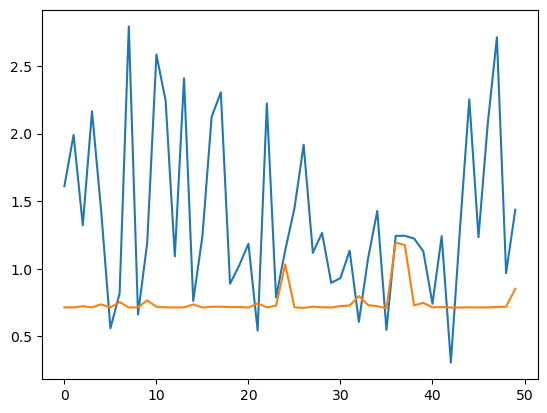

In [54]:
plt.plot(Y_test.index[0:50], Y_test.values[0:50])
plt.plot(Y_test.index[0:50], model_3_preds[0:50])

### Model 6C - Linear Regression

Inputs: Urban Pop, MEI, All CO2 Emissions, Sub-Region (Embeddings), Area (Embeddings)

In [61]:
model_6c_preds = model_6c.predict(x={
      'Urban Population': x_test[['urban_population']],
      'MEI': x_test[['mei']],
      'Crop Residues': x_test[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_test[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_test[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_test[['cum_sum_log_net_forest_conversion']],
      'Fires': x_test[['cum_sum_log_fires']],
      'Manure Management': x_test[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_test[['cum_sum_log_food_systems']],
      'IPPU Total': x_test[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_test[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_test[['cum_sum_forestland']],
      'Sub Region': x_test[['sub-region']],
      'Area': x_test[['area']]
    })

18/18 [==============================] - 0s 2ms/step


Test MAE: 0.388
Test RMSE: 0.500


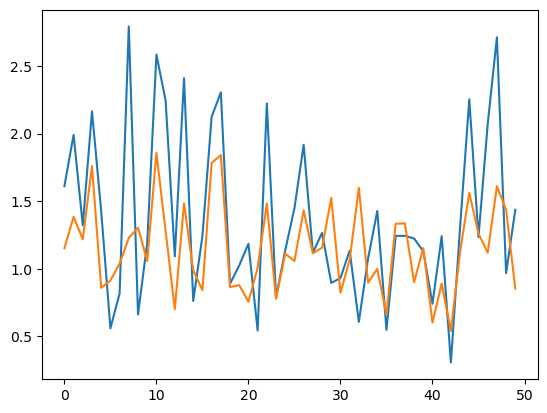

In [150]:
model_6c_mae = round(mae(Y_test, model_6c_preds),3)
model_6c_rmse = round(mse(Y_test, model_6c_preds, squared=False),3)
print('Test MAE: %.3f' %model_6c_mae)
print('Test RMSE: %.3f' %model_6c_rmse)
plt.plot(Y_test.index[0:50], Y_test.values[0:50])
plt.plot(Y_test.index[0:50], model_6c_preds[0:50])

### Model 8B - FFNN 2 Hidden Layers

Inputs: Urban Pop, MEI, All CO2 Emissions, Sub-Region (Embeddings), Area (Embeddings)

In [66]:
model_8b_preds = model_8b.predict(x={
      'Urban Population': x_test[['urban_population']],
      'MEI': x_test[['mei']],
      'Crop Residues': x_test[['cum_sum_log_crop_residues']],
      'Rice Cultivation': x_test[['cum_sum_log_rice_cultivation']],
      'Drained Organic Soils CO2': x_test[['cum_sum_log_drained_organic_soils_co2']],
      'Net Forest Conversion': x_test[['cum_sum_log_net_forest_conversion']],
      'Fires': x_test[['cum_sum_log_fires']],
      'Manure Management': x_test[['cum_sum_log_manure_mgmt']],
      'Food Systems': x_test[['cum_sum_log_food_systems']],
      'IPPU Total': x_test[['cum_sum_log_ippu_tot']],
      'On Farm Energy Use': x_test[['cum_sum_log_on_farm_energy_use']],
      'Forestland': x_test[['cum_sum_forestland']],
      'Sub Region': x_test[['sub-region']],
      'Area': x_test[['area']]
    })

18/18 [==============================] - 0s 2ms/step


In [151]:
model_8b_mae = round(mae(Y_test, model_8b_preds),3)
model_8b_rmse = round(mse(Y_test, model_8b_preds, squared=False),3)
print('Test MAE: %.3f' %model_8b_mae)
print('Test RMSE: %.3f' %model_8b_rmse)

Test MAE: 0.409
Test RMSE: 0.516


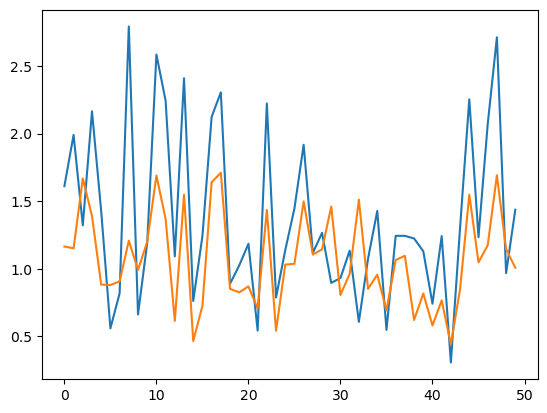

In [68]:
plt.plot(Y_test.index[0:50], Y_test.values[0:50])
plt.plot(Y_test.index[0:50], model_8b_preds[0:50])

### Model 13 - Regression Tree

In [168]:
predictions_13 = dt_model_4.predict(x_test_4)

mae_13 = mae(Y_test,predictions_13)
rmse_13 = mse(Y_test,predictions_13, squared=False)

print('final val mae:   %.3f' %mae_13)
print('final val rmse:   %.3f' %rmse_13)

final val mae:   0.497
final val rmse:   0.664


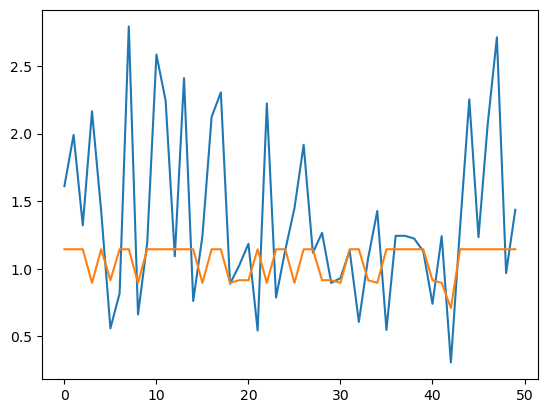

In [169]:
plt.plot(Y_test.index[0:50], Y_test.values[0:50])
plt.plot(Y_test.index[0:50], predictions_13[0:50])

### Model 14 - Random Forest

In [170]:
predictions_14 = rf_model.predict(x_test_4)

mae_14 = mae(Y_test,predictions_14)
rmse_14 = mse(Y_test,predictions_14, squared=False)

print('final val mae:   %.3f' %mae_14)
print('final val rmse:   %.3f' %rmse_14)

final val mae:   0.519
final val rmse:   0.697


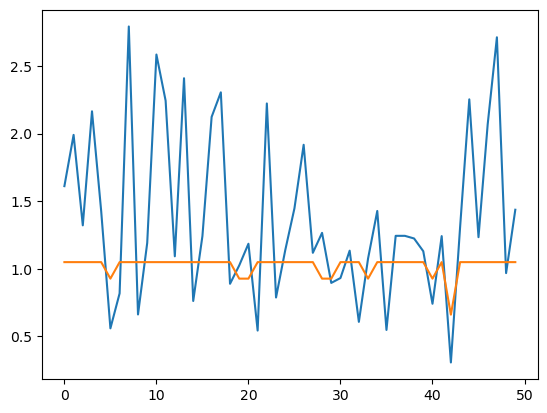

In [171]:
plt.plot(Y_test.index[0:50], Y_test.values[0:50])
plt.plot(Y_test.index[0:50], predictions_14[0:50])

### Model 16 - XGBoost

In [86]:
preds_16 = my_xgb.predict(x_test_4)

mae_16 = mae(Y_val,preds_16)
rmse_16 = mse(Y_val,preds_16, squared=False)

print('final val mae:   %.3f' %mae_16)
print('final val rmse:   %.3f' %rmse_16)

final val mae:   0.428
final val rmse:   0.545


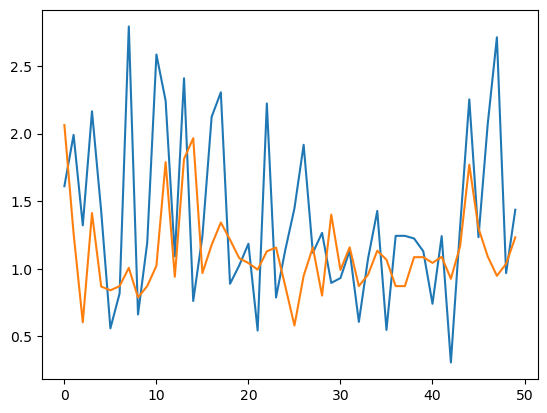

In [87]:
plt.plot(Y_test.index[0:50], Y_test.values[0:50])
plt.plot(Y_test.index[0:50], preds_16[0:50])

## Create DataFrame of Model History

In [267]:
#Create df with model  history
model_history = pd.DataFrame()
model_history[0] = [model_1_mae,model_3_mae,model_6c_mae,model_8b_mae, mae_13, mae_14, mae_16]
model_history[1] = [model_1_rmse,model_3_rmse,model_6c_rmse,model_8b_rmse, rmse_13, rmse_14, rmse_16]

In [268]:
#Rename rows and cols
model_history = model_history.rename(columns={0: 'MAE', 1:'RMSE'})
model_history = model_history.rename(index={0: "Baseline Simple", 1: 'Baseline Advanced', 2: "Linear Regression", 3: "FFNN", 4:'Regression Tree', 5:'Random Forest', 6:'XGBoost'})

In [269]:
#Round values in df
model_history = model_history.round(3)

In [271]:
model_history.sort_values(by=['MAE'])

,MAE,RMSE
Linear Regression,0.388,0.500
FFNN,0.409,0.516
XGBoost,0.428,0.545
Regression Tree,0.497,0.664
Random Forest,0.519,0.697
Baseline Advanced,0.743,0.916
Baseline Simple,0.755,0.923
